# Erkennung von amerikanischer Zeichensprache

Dieses Projekt wurde bearbeitet von Kilian Lorenz und Tjark Gerken.

---

Der Inhalt umfasst die Erkennung amerikanischen Zeichen für Buchstaben, die keine Bewegungen beinhalten.
Diese sind A, B, C, D, E, F, G, H, I, K, L, M, N, O, P, Q, R, S, T, U, V, W, X und Y. Andere Zeichen sind derzeit nicht erkennbar.

Das Projekt basiert auf dem folgenden Datensatz:
https://www.kaggle.com/datasets/datamunge/sign-language-mnist

## Importieren der notwendigen Libraries

Das Projekt nutzt Keras zum Erstellen der Modelle. Notwendige andere Bibliotheken sind Matplotlib und Seaborn zum erstellen der Grafiken. Os, random, Pandas und numpy sind als Standard Bibliotheken ebenfalls notwendig.

## Importieren der Daten und Aufsetzen des Projekts
Die Daten werden aus dem Speicherort geladen

Standardmäßig wird das Modell nicht bei jedem Durchlauf neu trainiert, um einfachere Nutzbarkeit zu ermöglichen. Sollte es gewünscht sein kann die Variable Retrain auf True gesetzt werden und der Trainingsprozess wird erneut durchlaufen. Das Jupyter Notebook speichert die Modelle und benötigten Daten für die Grafiken in einem Ordner ab der standardmäßig "models" heißt ab, dieser Ort kann mit der Variable "cache_path" festgelegt werden.

Wenn der Cache Path nicht existiert oder einer der benötigten Dateien fehlt, wird die Variable retrain auf True gesetzt, dementsprechend wird der Trainingsprozess durchlaufen und die benötigten Daten generiert.

Es ist zum Empfehlen diese Einstellungen nicht zu verändern.




In [43]:
# Basic Packages
import random
import numpy as np
import os
import pandas as pd

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# ML
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.models import Sequential
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics
from sklearn.preprocessing import LabelBinarizer

In [67]:
# Verändere diese Variable, um das Modell neu zu trainieren:
retrain = True

cache_path = "./models/"
model_name = "american_dataset.h5"
training_history = "training_history.csv"

if not os.path.isdir(cache_path):
    os.mkdir(cache_path)

if not os.path.exists(cache_path + model_name) or not os.path.exists(cache_path + training_history):
    retrain = True


plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.figsize"] = [20, 15]

train_df = pd.read_csv("data/sign_mnist_train/sign_mnist_train.csv")
test_df = pd.read_csv("data/sign_mnist_test/sign_mnist_test.csv")


# train_df = pd.read_csv("data/sign_mnist_train.csv")
# test_df = pd.read_csv("data/sign_mnist_test.csv")
print(retrain)

False


array([ 3,  6,  2, 13, 16,  8, 22, 18, 10, 20, 17, 19, 21, 23, 24,  1, 12,
       11, 15,  4,  0,  5,  7, 14])

# Exploration des Datensatzes

Es werden im Folgenden die Anzahl der Einträge, sowie die Verteilung dieser Einträge auf die unterschiedlichen Klassen beachtet.

In [61]:
classes= ["A","B","C","D","E","F","G","H","I","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y"]

train_num_samples = len(train_df)
test_num_samples = len(test_df)
print(f"{'=' * 10} Exploration of the Data Set {'=' * 10}")
print(f'Anzahl an Trainingsdaten: \t {train_num_samples} Einträge')
print(f'Anzahl an Testdaten: \t\t {test_num_samples} Einträge')
print(f"{'=' * 10} Exploration of the Data Set {'=' * 10}")

========== Exploration of the Data Set ==========
Anzahl an Trainingsdaten: 	 27455 Einträge
Anzahl an Testdaten: 		 7172 Einträge
========== Exploration of the Data Set ==========


Verteilung des Datensatzes

Text(0.5, 1.0, 'Verteilung der Label')

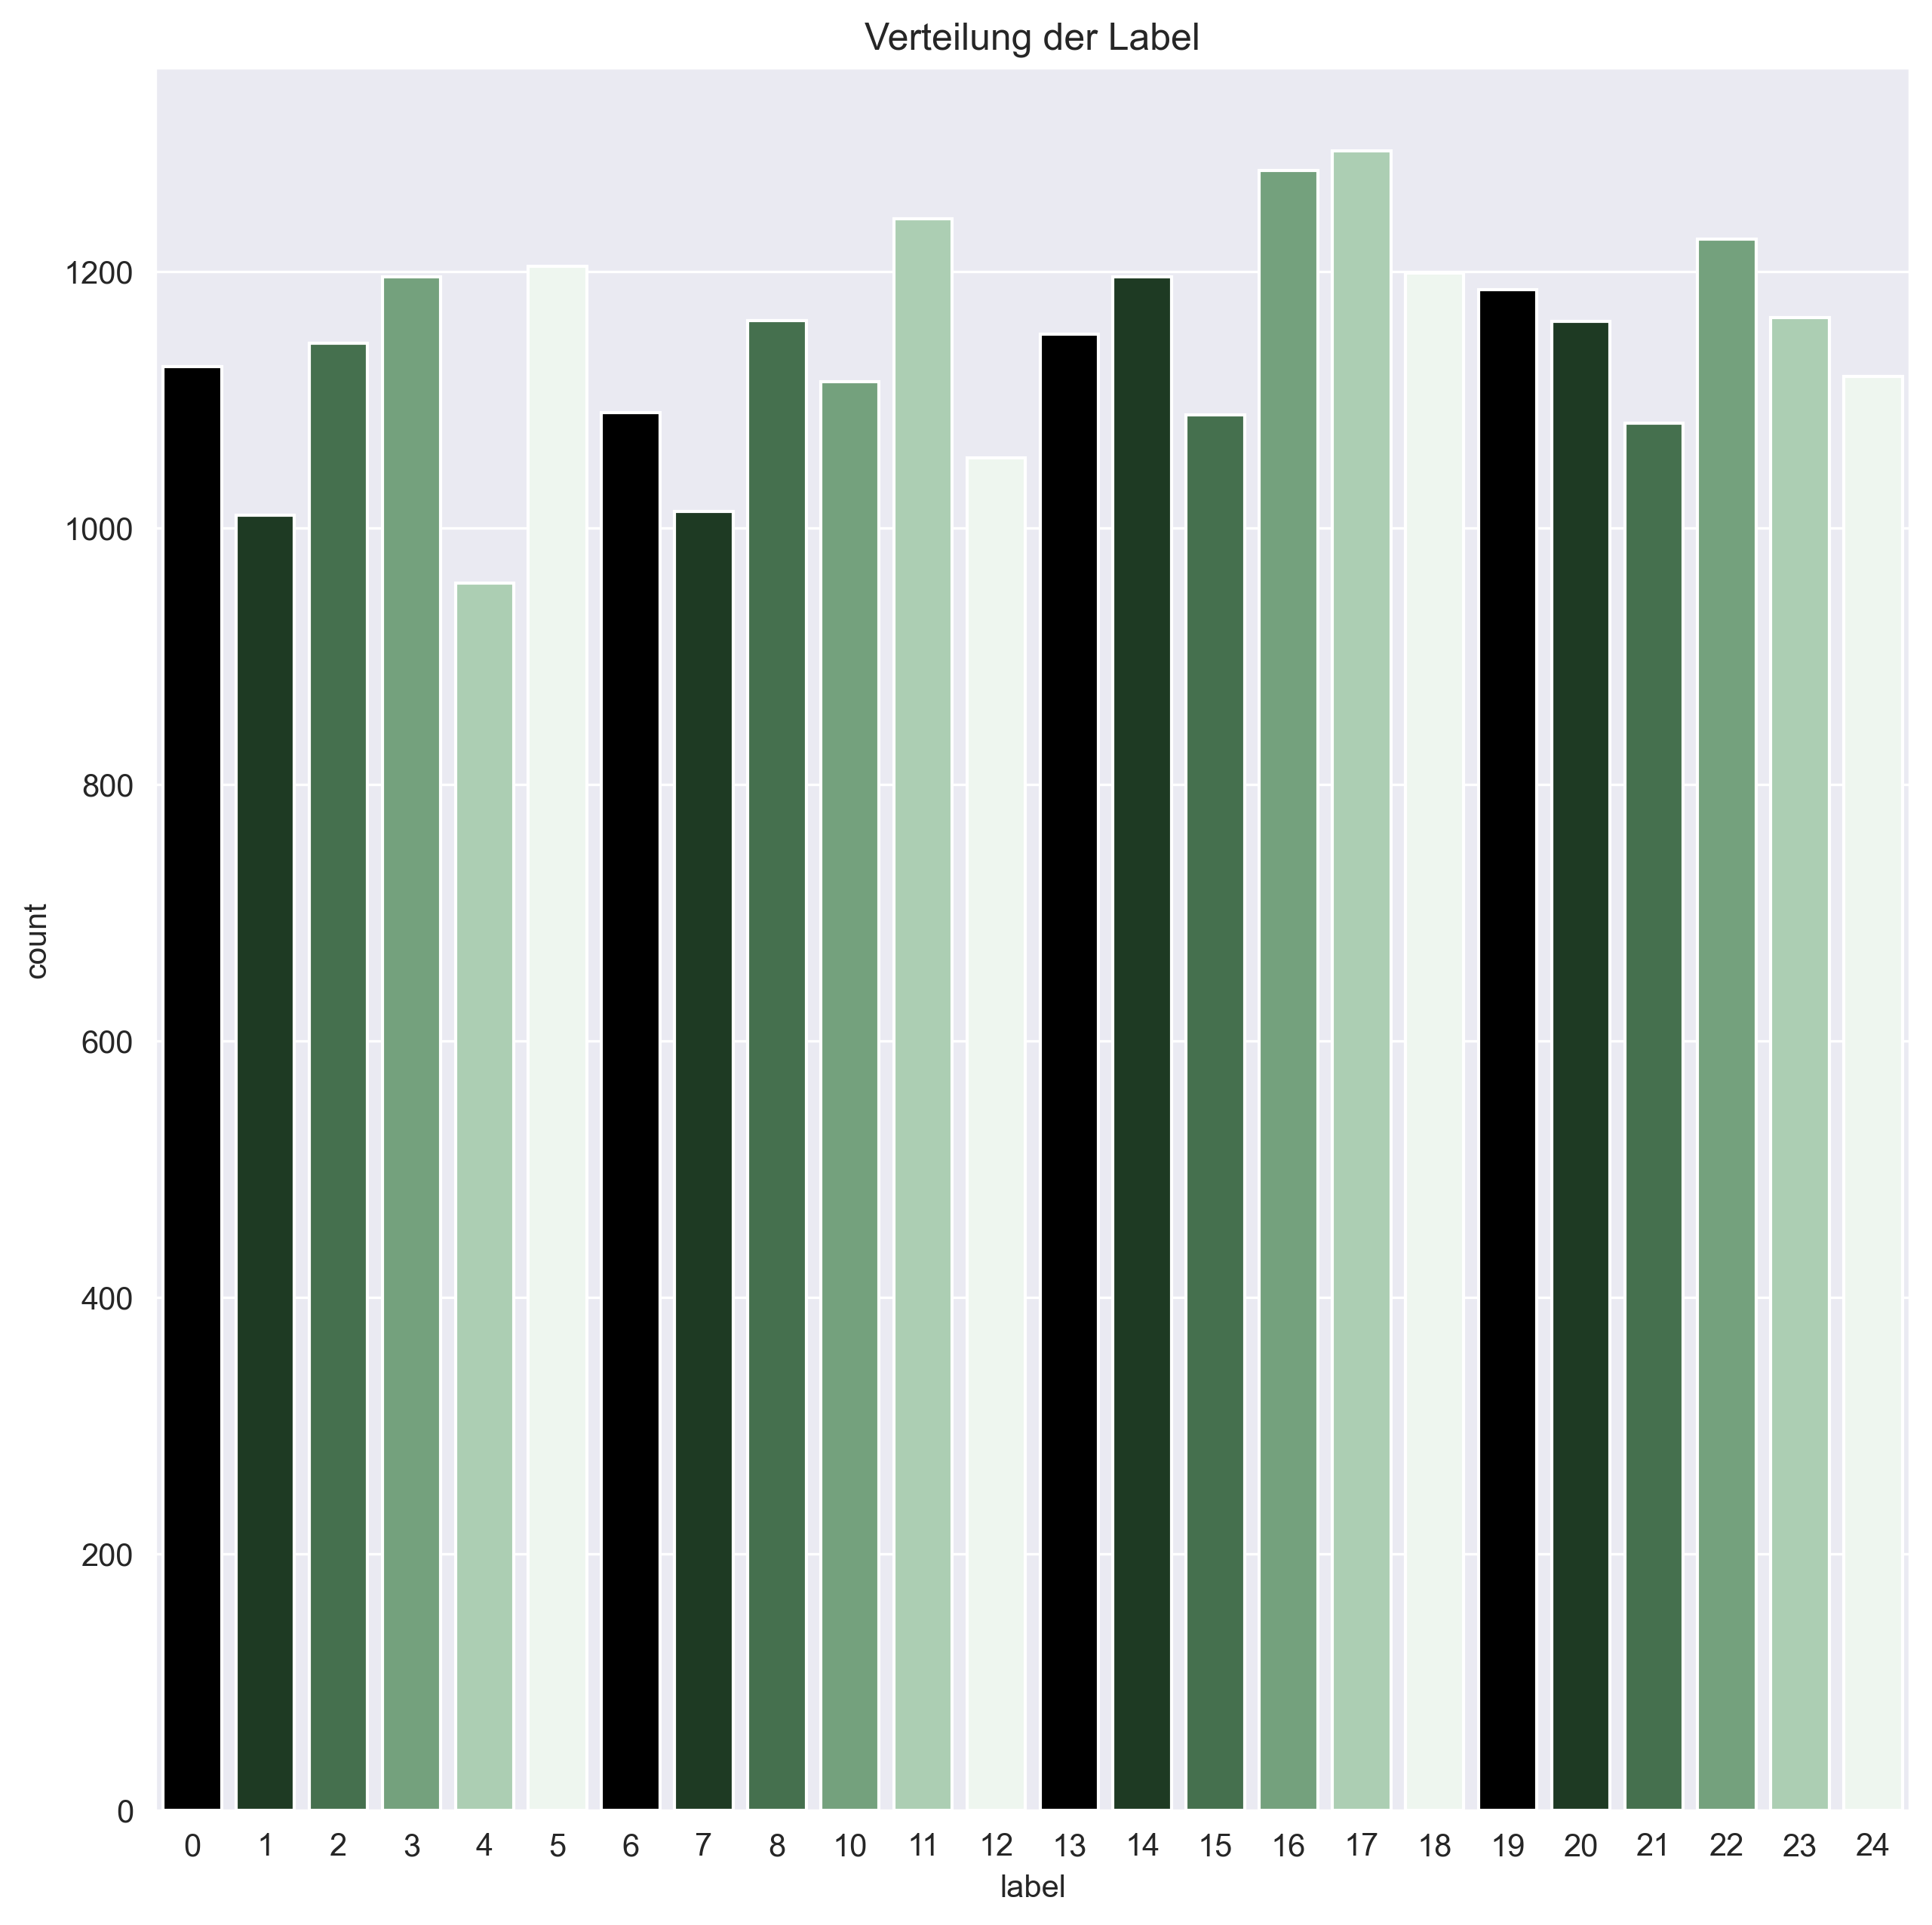

In [76]:
plt.figure(figsize = (10,10))

sns.countplot(train_df['label'])
plt.title("Verteilung der Label")

## Normalisierung des Datensatzes

Im Folgenden wird er Datensatz für die Verwendung zum Training des Machine Learning Models normalisiert.

In [47]:
y_train = train_df['label']
y_test = test_df['label']
del train_df['label']
del test_df['label']

In [48]:
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

x_train = train_df.values
x_test = test_df.values

x_train = x_train / 255
x_test = x_test / 255

x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)


print("=" * 10 + " Ausgabe der Dimensionen der Datensätze " + "=" * 10 )
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print("=" * 10 + " Ausgabe der Dimensionen der Datensätze " + "=" * 10 )

========== Ausgabe der Dimensionen der Datensätze ==========
(27455, 28, 28, 1)
(27455, 24)
(7172, 28, 28, 1)
(7172, 24)
========== Ausgabe der Dimensionen der Datensätze ==========


## Image Generator

Erstellen eines Image Generators, welcher es uns erlaubt die Trainingsdaten zu verändern um so weitere Trainingsdaten zu generieren.

In [49]:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.1, # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

## Model
Erstellen des Machine Learning Models

### ChatGPT Antwort:
Dieser Code definiert ein sequentielles Modell in Keras, das zur Klassifizierung von Bildern verwendet werden kann. Das Modell besteht aus mehreren Schichten, die nacheinander hinzugefügt werden:

Die erste Schicht ist eine Conv2D-Schicht mit 75 Filtern, einem Filterkernel der Größe (3,3), einer Schrittweite (stride) von 1 und einer "same"-Polsterung. Die Aktivierungsfunktion ist die ReLU-Funktion. Die Eingangsform der Schicht ist (28,28,1), was bedeutet, dass jedes Eingangsbild eine Größe von 28x28 Pixeln hat und eine Farbtiefe von 1 aufweist (in diesem Fall Graustufenbilder).

Die nächste Schicht ist eine Batch-Normalisierungsschicht, die die Ausgabe der vorherigen Conv2D-Schicht normalisiert.

Die nächste Schicht ist eine MaxPooling2D-Schicht mit einem Pooling-Kernel der Größe (2,2), einer Schrittweite von 2 und einer "same"-Polsterung. Dies reduziert die Größe der Ausgabe der vorherigen Schicht um den Faktor 2 und hilft, Überanpassungen zu vermeiden.

Die nächsten Schichten sind wieder Conv2D-, Batch-Normalisierungs- und MaxPooling2D-Schichten, aber mit weniger Filtern und ohne Dropout-Schicht. Jede Schicht reduziert die Größe des Ausgangs des vorherigen Layers durch Faktor 2.

Nach den Pooling-Schichten wird die Ausgabe der letzten MaxPooling2D-Schicht mit einer Flatten-Schicht in eine eindimensionale Darstellung umgewandelt.

Dann folgt eine Dense-Schicht mit 512 Neuronen und einer ReLU-Aktivierungsfunktion. Die Dense-Schicht ist vollständig mit allen Neuronen der vorherigen Schicht verbunden.

Die nächste Schicht ist eine Dropout-Schicht mit einer Rate von 0,3. Dies hilft bei der Vermeidung von Überanpassung.

Die letzte Schicht ist eine Dense-Schicht mit 24 Neuronen und einer Softmax-Aktivierungsfunktion. Dies ist die Ausgabeschicht, die die Vorhersage des Modells enthält.

Die Modellkonfiguration wird mit "adam" als Optimierer und "categorical_crossentropy" als Verlustfunktion und "accuracy" als Metrik definiert.

Schließlich wird das Modell mit der Methode summary() ausgegeben, die eine Zusammenfassung der Architektur des Modells und der Anzahl der Parameter ausgibt.

In [50]:
model = Sequential()
model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 24 , activation = 'softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 75)        750       
                                                                 
 batch_normalization_6 (Batc  (None, 28, 28, 75)       300       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 75)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 50)        33800     
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 50)        0         
                                                                 
 batch_normalization_7 (Batc  (None, 14, 14, 50)      

Der Output zeigt die Zusammenfassung des Modells, das du mit dem Code erstellt hast. Jede Schicht des Modells wird als eine Zeile dargestellt. Die erste Zeile gibt Informationen über das Modell selbst und die Anzahl der Parameter an.

Die zweite Zeile beschreibt die erste Schicht, die ein sogenanntes Convolutional-Layer ist. Ein Convolutional-Layer ist eine Art von Schicht, die hauptsächlich in der Bildverarbeitung verwendet wird, um Muster in Bildern zu erkennen. Die Ausgangsform der Schicht ist (None, 28, 28, 75), was bedeutet, dass das Modell eine Eingabe mit einer Größe von 28x28 Pixeln und 1 Farbkanal erwartet und eine Ausgabe mit einer Größe von 28x28 Pixeln und 75 Feature-Maps erzeugt. Die Anzahl der Parameter für diese Schicht beträgt 750.

Die dritte Zeile zeigt eine Batch-Normalization-Schicht. Die Batch-Normalization ist eine Technik, die in neuronalen Netzwerken verwendet wird, um das Training zu beschleunigen und die Stabilität des Modells zu verbessern. Der Output-Shape ist gleich der Input-Shape, also (None, 28, 28, 75). Die Anzahl der Parameter für diese Schicht beträgt 300.

Die vierte Zeile zeigt eine Max-Pooling-Schicht. Max-Pooling ist eine Technik, die verwendet wird, um die Größe des Ausgangs des Convolutional-Layers zu reduzieren und die Berechnungszeit zu verringern. Die Ausgangsform der Schicht ist (None, 14, 14, 75), was bedeutet, dass die Größe des Ausgangs des vorherigen Layers auf 14x14 Pixel reduziert wurde. Die Anzahl der Parameter für diese Schicht beträgt 0, da es keine trainierbaren Parameter in einer Max-Pooling-Schicht gibt.

Die folgenden Schichten folgen einem ähnlichen Muster, wobei verschiedene Typen von Schichten, wie Convolutional-Layers, Dropout-Layers und Dense-Layers, kombiniert werden, um das Modell zu erstellen.

Die letzte Zeile gibt die Anzahl der Gesamtparameter des Modells an, die 264.049 beträgt. Davon sind 263.749 Parameter trainierbar, was bedeutet, dass das Modell diese Parameter während des Trainings aktualisieren wird, um bessere Vorhersagen zu treffen. Die restlichen 300 Parameter sind nicht trainierbar und gehören zu den Batch-Normalization-Schichten.

In [51]:
if retrain:
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)
    history = model.fit(datagen.flow(x_train,y_train, batch_size = 128), epochs = 20 , validation_data = (x_test, y_test) , callbacks = [learning_rate_reduction])
    model.save(cache_path + model_name)
    history = pd.DataFrame(history.history)
    history.to_csv(cache_path + training_history)
else:
    model = load_model(cache_path + model_name)
    history = pd.read_csv(cache_path + training_history)

Text(0.5, 1.0, 'Zeitliche Entwicklung der Accuracy (Vergrößert)')

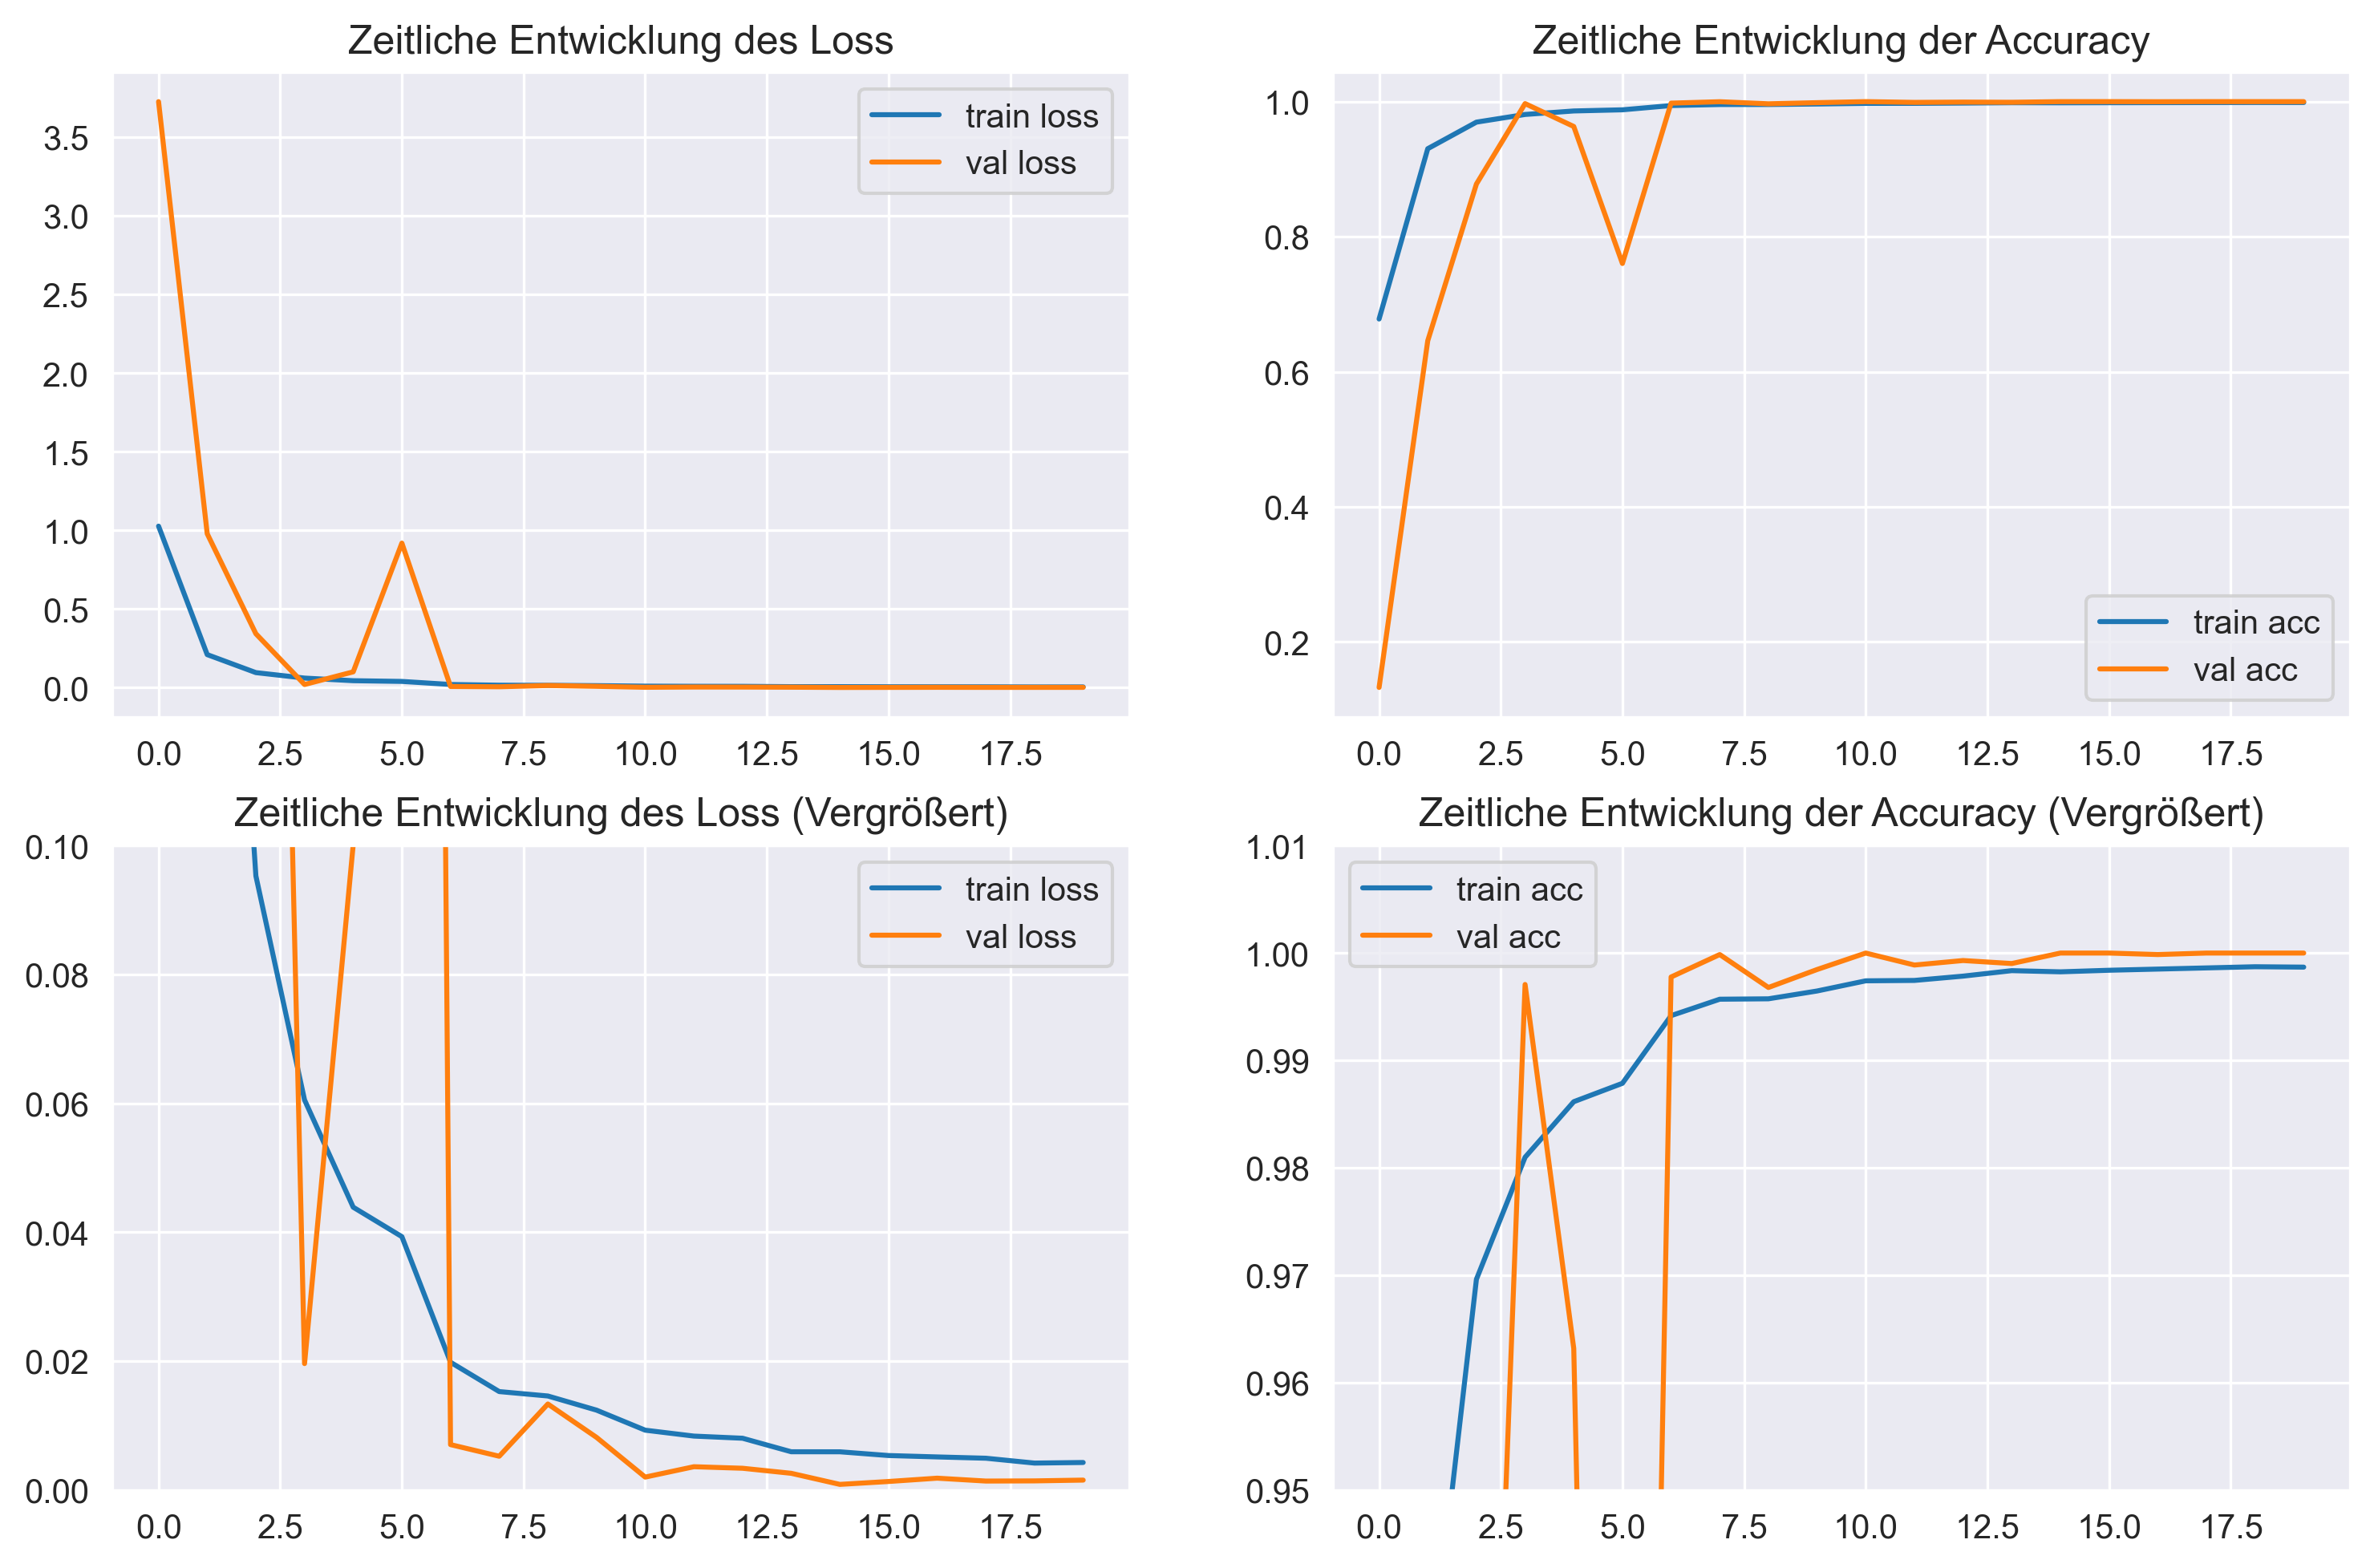

In [52]:
plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='val loss')
plt.legend()
plt.title("Zeitliche Entwicklung des Loss")

plt.subplot(4, 2, 2)

plt.plot(history['accuracy'], label='train acc')
plt.plot(history['val_accuracy'], label='val acc')

plt.legend()
plt.title("Zeitliche Entwicklung der Accuracy")


plt.subplot(4, 2, 3)
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='val loss')
plt.legend()
plt.ylim([0, 0.1])
plt.title("Zeitliche Entwicklung des Loss (Vergrößert)")

plt.subplot(4, 2, 4)

plt.plot(history['accuracy'], label='train acc')
plt.plot(history['val_accuracy'], label='val acc')
plt.ylim([0.95, 1.01])
plt.legend()
plt.title("Zeitliche Entwicklung der Accuracy (Vergrößert)")

In [53]:
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print(f"{'=' * 10} Evaluation of the Test Data {'=' * 10}")
print(f"n Training Samples: \t{train_num_samples}\nn Test Samples:\t\t\t{test_num_samples}")
print(f"Loss: \t\t\t\t\t{loss:.5f}\nAccuracy:\t\t\t\t{acc:.5f}")
print(f"{'=' * 10} Evaluation of the Test Data {'=' * 10}")

========== Evaluation of the Test Data ==========
n Training Samples: 	27455
n Test Samples:			7172
Loss: 					0.00155
Accuracy:				1.00000
========== Evaluation of the Test Data ==========


In [54]:
predictions = model.predict(x_test)
prediction_classes = np.argmax(predictions, axis=-1)

gt_classes = np.argmax(y_test, axis=-1)
confusion_matrix = metrics.confusion_matrix(gt_classes, prediction_classes)

225/225 [==============================] - 2s 7ms/step


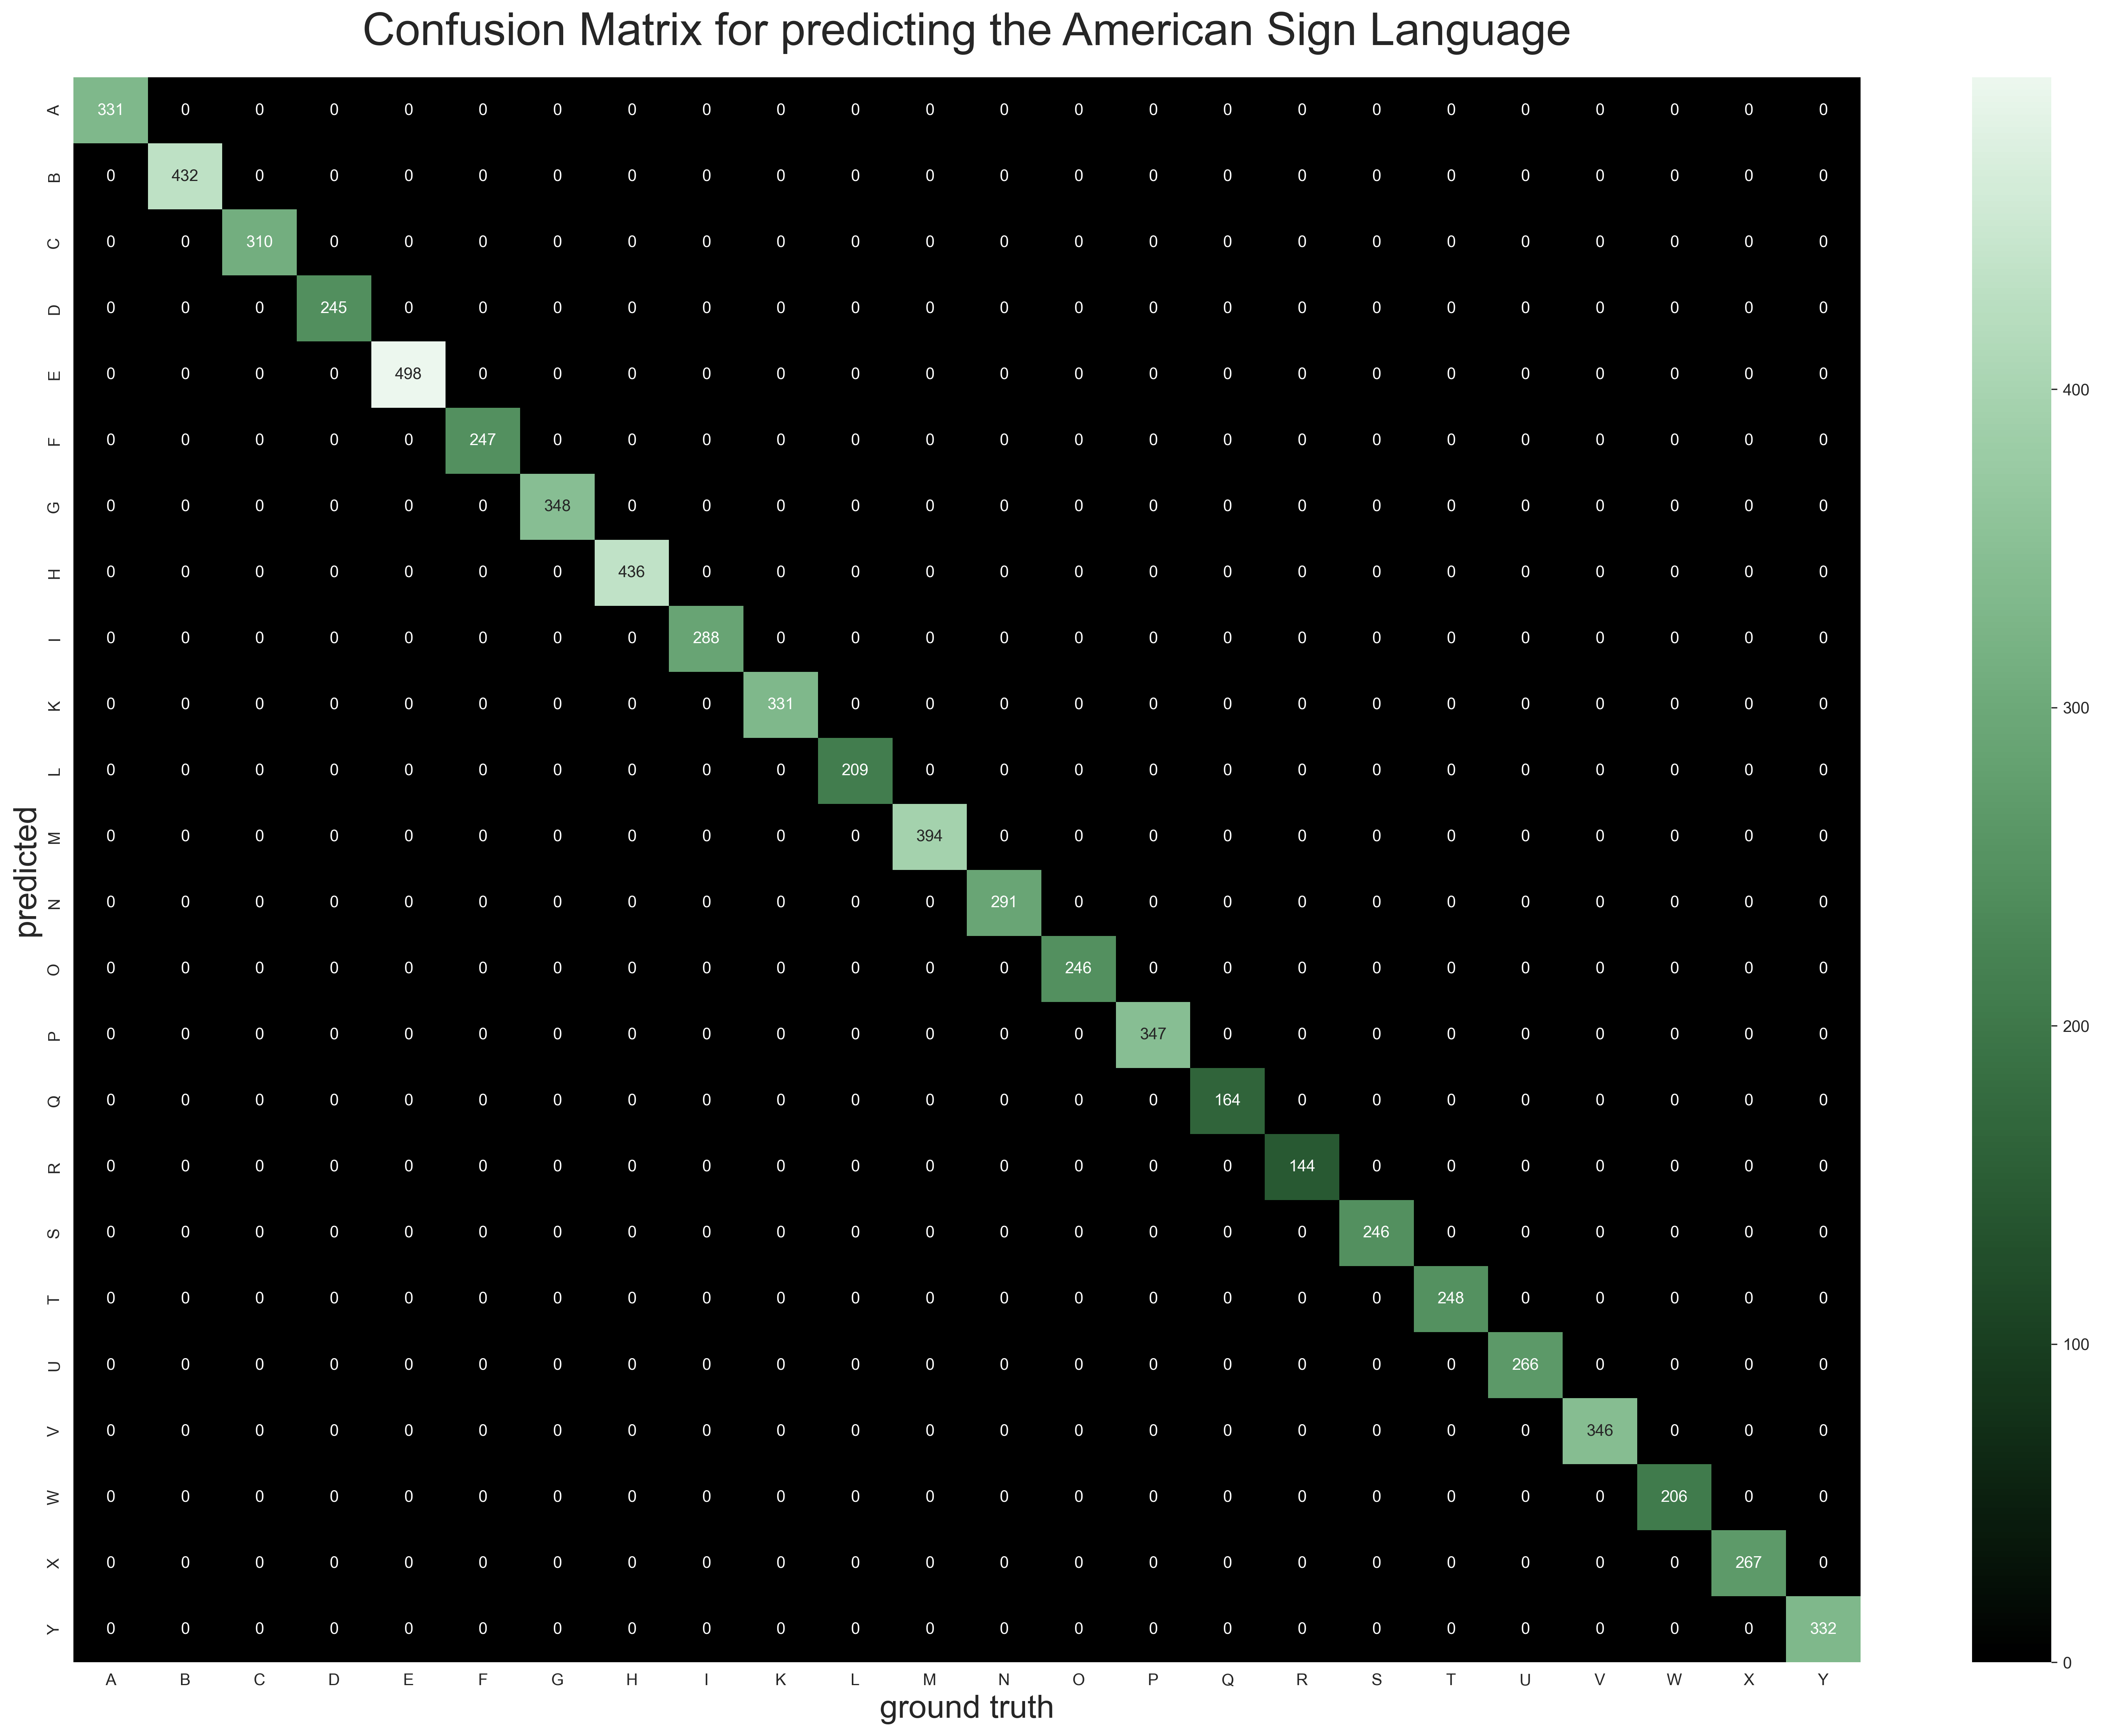

In [77]:
cmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
sns.heatmap(pd.DataFrame(confusion_matrix, index=classes, columns=classes), annot=True, cmap=cmap, fmt='d')
plt.title('Confusion Matrix for predicting the American Sign Language', fontsize=28, pad=20)
plt.ylabel('predicted', fontsize=20)
plt.xlabel('ground truth', fontsize=20)
plt.tight_layout()
plt.show()

In [56]:
amount_of_samples = 24


random.seed(3) # to make this deterministic
sample_indexes = random.sample(range(len(x_test)), amount_of_samples)
sample_images = [x_test[i] for i in sample_indexes]
sample_labels = [y_test[i] for i in sample_indexes]

ground_truth = np.argmax(sample_labels, axis=1)

X_sample = np.array(sample_images)
prediction = model.predict(X_sample)
predicted_categories = np.argmax(prediction, axis=1)

1/1 [==============================] - 0s 26ms/step


In [57]:
# Display the predictions and the ground truth visually.
def display_prediction (images, true_labels, predicted_labels):
    fig = plt.figure(figsize=(20, amount_of_samples +10))
    for i in range(len(true_labels)):
        truth = true_labels[i]
        prediction = predicted_labels[i]
        plt.subplot(amount_of_samples, 4,1+i)
        plt.axis('off')
        color='green' if truth == prediction else 'red'
        plt.text(30, 10, f"Truth:           {classes[truth]}\nPrediction:   {classes[prediction]}",
                 fontsize=12, color=color)
        plt.imshow(images[i])


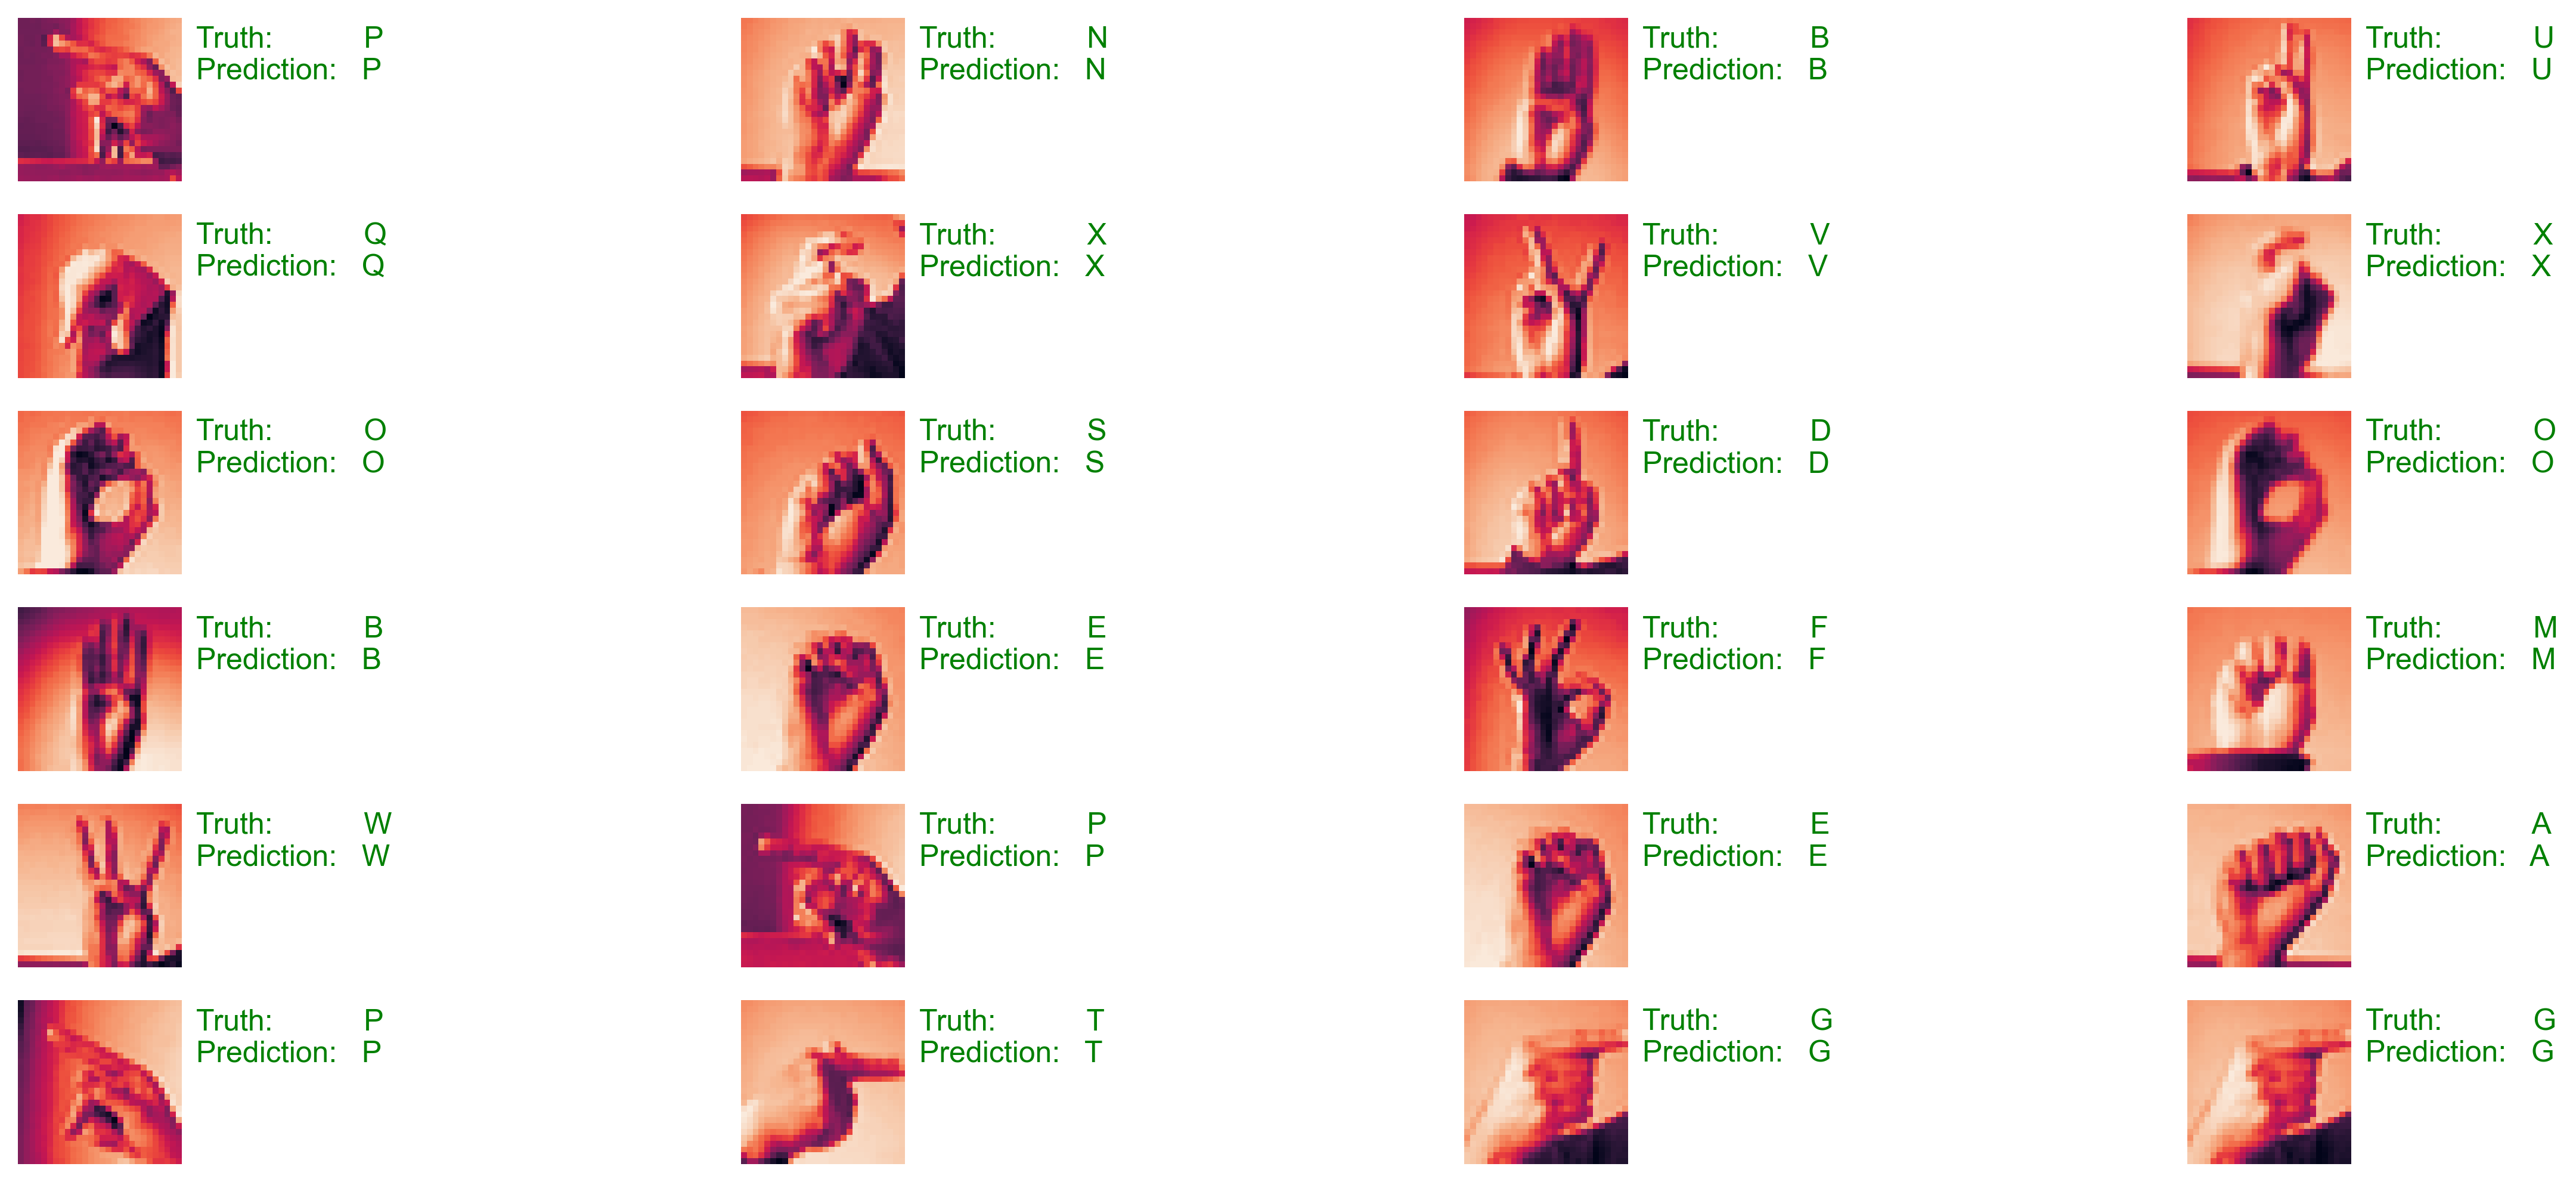

In [58]:
display_prediction(sample_images, ground_truth, predicted_categories)

In [59]:
ground_truth, predicted_categories

(array([14, 12,  1, 19, 15, 22, 20, 22, 13, 17,  3, 13,  1,  4,  5, 11, 21,
        14,  4,  0, 14, 18,  6,  6]),
 array([14, 12,  1, 19, 15, 22, 20, 22, 13, 17,  3, 13,  1,  4,  5, 11, 21,
        14,  4,  0, 14, 18,  6,  6]))